NLP Project: Classification of ‘Triggering’ Content on Social Media CSCI 4152 - Natural Language Processing

Keelin Sekerka-Bajbus

**Data Pre-processing and Model Selection**

In [1]:
# import libraries
import csv
import time
import pandas as pd
import os
import sys
import numpy as np
import io
from google.colab import files
import gensim
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# upload dataset
uploaded= files.upload()
df = pd.read_csv(io.BytesIO(uploaded['trigger_warnings_dataset.csv']), index_col=0)

Saving trigger_warnings_dataset.csv to trigger_warnings_dataset.csv


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Merge the old data set and new dataset (drop duplicates).

In [5]:
uploaded= files.upload()
df_old = pd.read_csv(io.BytesIO(uploaded['dataset_triggers.csv']), index_col=0)

Saving dataset_triggers.csv to dataset_triggers (1).csv


In [7]:
df = pd.concat([df,df_old])

In [6]:
df.tail()

,title,selftext,class
24324,Athletes are abused by coaches and why are the...,NaN,Abuse
24329,Blaming the innocence of a child,"When I was 6, when my parents split up my moth...",Abuse
24330,The journey of surviving abuse and reinventing...,I am currently in the process of writing this ...,Abuse
24332,UCI team is first to capture motion of single ...,NaN,Abuse
24333,Lets put up a link to the discussion that spaw...,NaN,Abuse


In [9]:
df.drop_duplicates()

,title,selftext,class
7,Suicidal Partner,My boyfriend has been depressed and suicidal s...,Suicide
10,Why does there always have to be a reason to f...,when im honest with my dad if im anxious depre...,Suicide
17,my friend's attempted and i dont know how to r...,"hi, i just got a suicidal note/message from a ...",Suicide
20,Im scared of myself,I literally think about it hourly. Im so hideo...,Suicide
22,I dont want to die,But I dont really see a way out of this I have...,Suicide
...,...,...,...
163139,Narc(issist)'s Bride Wants Out,Together almost 2 years. I have bailed him out...,Abuse
163141,"Dirty, abused and confused?? *trigger warning*",I'll start with Hi. I'm 18 and about a year ag...,Abuse
163151,I need help. Girlfriend won't let me leave her.,"Hi, first post ever. I'm at work so typing thi...",Abuse
163155,Need some advice from GOOD men,"20 year old Female, 22 year old male\nTL;DR; ...",Abuse


In [10]:
df.shape

(377134, 3)

In [11]:
# download concatenated dataset to make full dataset
df.to_csv('trigger_warnings_dataset.csv',encoding='utf-8')
files.download("trigger_warnings_dataset.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
df.head()

,title,selftext,class
7,Suicidal Partner,My boyfriend has been depressed and suicidal s...,Suicide
10,Why does there always have to be a reason to f...,when im honest with my dad if im anxious depre...,Suicide
17,my friend's attempted and i dont know how to r...,"hi, i just got a suicidal note/message from a ...",Suicide
20,Im scared of myself,I literally think about it hourly. Im so hideo...,Suicide
22,I dont want to die,But I dont really see a way out of this I have...,Suicide


Step 1: Concatenate Title and Selftext 

In [5]:
df['text'] = df['title']+' '+df['selftext']
df.head()

,title,selftext,class,text
7,Suicidal Partner,My boyfriend has been depressed and suicidal s...,Suicide,Suicidal Partner My boyfriend has been depress...
10,Why does there always have to be a reason to f...,when im honest with my dad if im anxious depre...,Suicide,Why does there always have to be a reason to f...
17,my friend's attempted and i dont know how to r...,"hi, i just got a suicidal note/message from a ...",Suicide,my friend's attempted and i dont know how to r...
20,Im scared of myself,I literally think about it hourly. Im so hideo...,Suicide,Im scared of myself I literally think about it...
22,I dont want to die,But I dont really see a way out of this I have...,Suicide,I dont want to die But I dont really see a way...


In [6]:
df.drop(columns=['title','selftext'], inplace=True)
df.head()

,class,text
7,Suicide,Suicidal Partner My boyfriend has been depress...
10,Suicide,Why does there always have to be a reason to f...
17,Suicide,my friend's attempted and i dont know how to r...
20,Suicide,Im scared of myself I literally think about it...
22,Suicide,I dont want to die But I dont really see a way...


In [7]:
df.shape

(377134, 2)

In [8]:
# drop null value rows
df = df.dropna()
df.shape

(363641, 2)

Step 2: Transform all text to lowercase

In [9]:
df['text'] = df['text'].str.lower()
df.head()

,class,text
7,Suicide,suicidal partner my boyfriend has been depress...
10,Suicide,why does there always have to be a reason to f...
17,Suicide,my friend's attempted and i dont know how to r...
20,Suicide,im scared of myself i literally think about it...
22,Suicide,i dont want to die but i dont really see a way...


In [10]:
df = df[['text', 'class']]
df.head()

,text,class
7,suicidal partner my boyfriend has been depress...,Suicide
10,why does there always have to be a reason to f...,Suicide
17,my friend's attempted and i dont know how to r...,Suicide
20,im scared of myself i literally think about it...,Suicide
22,i dont want to die but i dont really see a way...,Suicide


Step 3: Remove any links from the data using regex (starts with https://)

In [11]:
df['text'] = df['text'].str.replace('https:\S+|www.\S+', '', case=False)
df.head()

,text,class
7,suicidal partner my boyfriend has been depress...,Suicide
10,why does there always have to be a reason to f...,Suicide
17,my friend's attempted and i dont know how to r...,Suicide
20,im scared of myself i literally think about it...,Suicide
22,i dont want to die but i dont really see a way...,Suicide


In [ ]:
df.iloc[138456]['text']

Step 5: Tokenize, remove punctuation and excessive characters,  and remove stop words using NLTK library

In [12]:
df['token_text'] = df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)
df.head()

,text,class,token_text
7,suicidal partner my boyfriend has been depress...,Suicide,"[suicidal, partner, my, boyfriend, has, been, ..."
10,why does there always have to be a reason to f...,Suicide,"[why, does, there, always, have, to, be, a, re..."
17,my friend's attempted and i dont know how to r...,Suicide,"[my, friend, 's, attempted, and, i, dont, know..."
20,im scared of myself i literally think about it...,Suicide,"[im, scared, of, myself, i, literally, think, ..."
22,i dont want to die but i dont really see a way...,Suicide,"[i, dont, want, to, die, but, i, dont, really,..."


In [13]:
stop_words = nltk.corpus.stopwords.words("english")
df['token_text'] = df['token_text'].apply(lambda x: [item for item in x if item not in stop_words] )
df.head()

,text,class,token_text
7,suicidal partner my boyfriend has been depress...,Suicide,"[suicidal, partner, boyfriend, depressed, suic..."
10,why does there always have to be a reason to f...,Suicide,"[always, reason, feel, ?, im, honest, dad, im,..."
17,my friend's attempted and i dont know how to r...,Suicide,"[friend, 's, attempted, dont, know, reach, hi,..."
20,im scared of myself i literally think about it...,Suicide,"[im, scared, literally, think, hourly, ., im, ..."
22,i dont want to die but i dont really see a way...,Suicide,"[dont, want, die, dont, really, see, way, depr..."


In [14]:
# remove punctuation, non-letter characters
df['token_text'] = df['token_text'].apply(lambda x: [item for item in x if re.match('[a-z]+', item)] )
df.head()

,text,class,token_text
7,suicidal partner my boyfriend has been depress...,Suicide,"[suicidal, partner, boyfriend, depressed, suic..."
10,why does there always have to be a reason to f...,Suicide,"[always, reason, feel, im, honest, dad, im, an..."
17,my friend's attempted and i dont know how to r...,Suicide,"[friend, attempted, dont, know, reach, hi, got..."
20,im scared of myself i literally think about it...,Suicide,"[im, scared, literally, think, hourly, im, hid..."
22,i dont want to die but i dont really see a way...,Suicide,"[dont, want, die, dont, really, see, way, depr..."


Dataset Information

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 363641 entries, 7 to 163158
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        363641 non-null  object
 1   class       363641 non-null  object
 2   token_text  363641 non-null  object
dtypes: object(3)
memory usage: 11.1+ MB


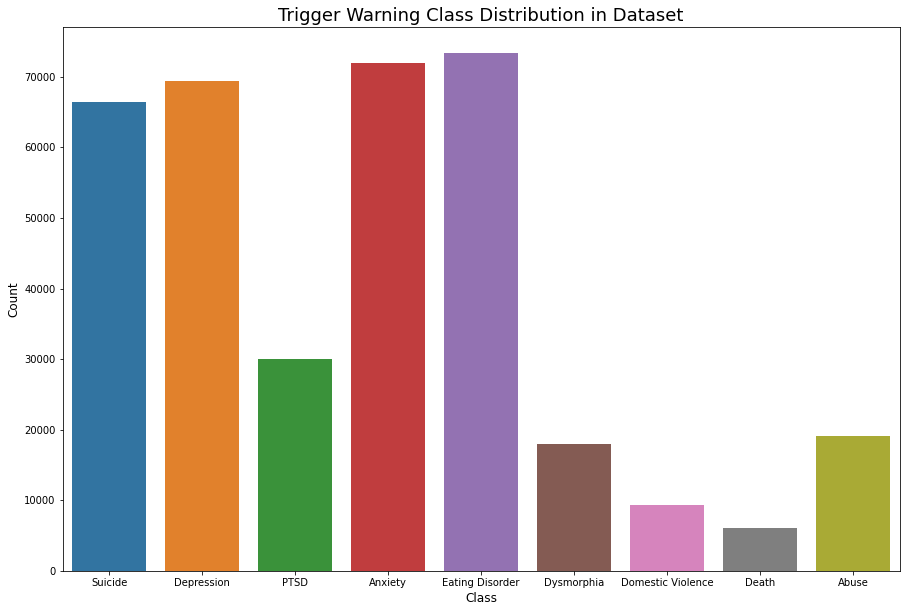

In [24]:
# class distribution
plt.figure(figsize = (15,10))
ax = sns.countplot(x='class',data=df)
plt.title("Trigger Warning Class Distribution in Dataset", size = 18)
plt.xlabel("Class", size = 12)
plt.ylabel("Count", size = 12)
plt.show()


In [15]:
df['class'].value_counts()

Eating Disorder      73381
Anxiety              71917
Depression           69463
Suicide              66509
PTSD                 29965
Abuse                19144
Dysmorphia           17904
Domestic Violence     9329
Death                 6029
Name: class, dtype: int64

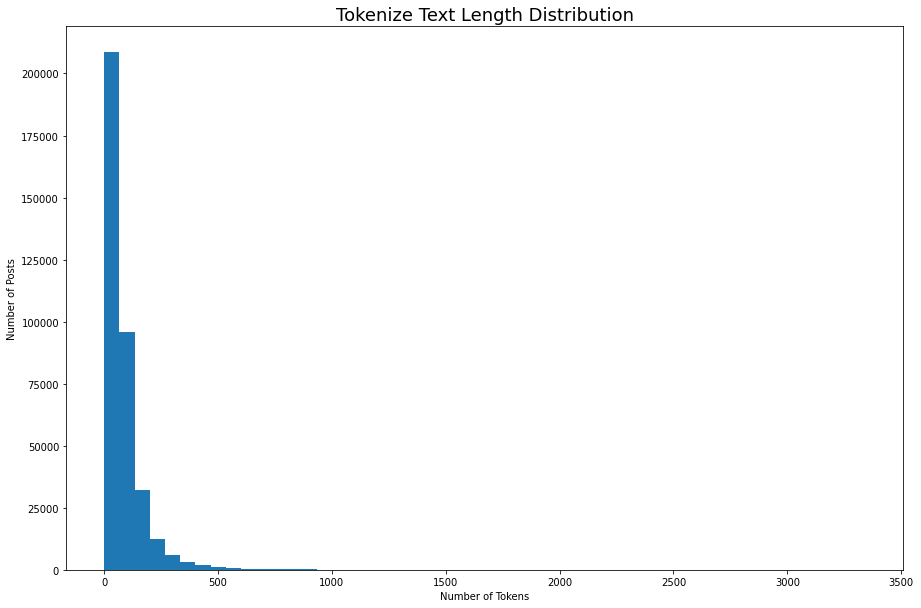

In [26]:
# post tokenized text lengths
length = [len(text) for text in df['token_text']]

plt.figure(figsize = (15,10))
plt.hist(length, bins=50)
plt.title("Tokenize Text Length Distribution", size = 18)
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Posts")
plt.show()

note: use token_text for word2vec models for the CNN, NN approaches. Use text for tfidf with encoder for classes

**Modeling**

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
import sklearn.metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics                 import accuracy_score, recall_score, roc_auc_score, matthews_corrcoef

In [39]:
X = df['token_text'].astype(str)
Y = df['class'].astype(str)

Train-Test Split (80-20 split)

In [40]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,Y,random_state = 42, test_size=0.2, stratify=Y)

In [41]:
print(X_train.shape)
print(X_test.shape)

(290912,)
(72729,)


Encode class categories 

In [23]:
classes_names = [
                 'Suicide',
                 'Depression',
                 'PTSD',
                 'Anxiety',
                 'Eating Disorder',
                 'Dysmorphia',
                 'Domestic Violence',
                 'Death',
                 'Abuse'
]

In [42]:
encoder = LabelEncoder()
encoder.fit(classes_names)
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)
print(encoder.classes_)

['Abuse' 'Anxiety' 'Death' 'Depression' 'Domestic Violence' 'Dysmorphia'
 'Eating Disorder' 'PTSD' 'Suicide']


In [71]:
integer_mapping = {l: i for i, l in enumerate(encoder.classes_)}
print(integer_mapping)

{'Abuse': 0, 'Anxiety': 1, 'Death': 2, 'Depression': 3, 'Domestic Violence': 4, 'Dysmorphia': 5, 'Eating Disorder': 6, 'PTSD': 7, 'Suicide': 8}


TF-DIF Vectorizer


In [ ]:
X

In [49]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(X)
Train_X_trans = Tfidf_vect.transform(X_train)
Test_X_trans = Tfidf_vect.transform(X_test)

In [50]:
vocab_dict = Tfidf_vect.vocabulary_
x = sorted(vocab_dict.items(), key=lambda x: x[1], reverse=True)
x

[('zoom', 4999),
 ('zone', 4998),
 ('zombie', 4997),
 ('zoloft', 4996),
 ('zero', 4995),
 ('yrs', 4994),
 ('yr', 4993),
 ('youve', 4992),
 ('youtube', 4991),
 ('youth', 4990),
 ('youre', 4989),
 ('youngest', 4988),
 ('younger', 4987),
 ('young', 4986),
 ('youll', 4985),
 ('youd', 4984),
 ('you', 4983),
 ('yogurt', 4982),
 ('yoga', 4981),
 ('yo', 4980),
 ('yet', 4979),
 ('yesterday', 4978),
 ('yes', 4977),
 ('yells', 4976),
 ('yelling', 4975),
 ('yelled', 4974),
 ('yell', 4973),
 ('years', 4972),
 ('year', 4971),
 ('yeah', 4970),
 ('yea', 4969),
 ('yay', 4968),
 ('yard', 4967),
 ('yall', 4966),
 ('ya', 4965),
 ('xanax', 4964),
 ('x200b', 4963),
 ('wtf', 4962),
 ('wrote', 4961),
 ('wrong', 4960),
 ('written', 4959),
 ('writing', 4958),
 ('write', 4957),
 ('wrists', 4956),
 ('wrist', 4955),
 ('wreck', 4954),
 ('wrapped', 4953),
 ('wrap', 4952),
 ('wow', 4951),
 ('wounds', 4950),
 ('wound', 4949),
 ('wouldve', 4948),
 ('wouldnt', 4947),
 ('would', 4946),
 ('worthy', 4945),
 ('worthless', 4

SVM Benchmark model

In [51]:
svm_model = svm.LinearSVC(random_state=42)
svm_model.fit(Train_X_trans,y_train_enc)
preds_SVM = svm_model.predict(Test_X_trans)
print(svm_model.score(Test_X_trans,y_test_enc))
print(svm_model.get_params())


0.764289348127982
{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42, 'tol': 0.0001, 'verbose': 0}


In [52]:
labes = ['Abuse', 'Anxiety', 'Death', 'Depression', 'Domestic Violence', 'Dysmorphia','Eating Disorder','PTSD','Suicide']

In [53]:
print("SVM Accuracy Score", accuracy_score(y_test_enc, preds_SVM))
print("Confusion matrix:\n",sklearn.metrics.confusion_matrix(y_test_enc, preds_SVM))
print("F1:",sklearn.metrics.f1_score(y_test_enc, preds_SVM,average='weighted'))
print("Precision:", sklearn.metrics.precision_score(y_test_enc, preds_SVM,average='weighted'))
print("Recall:", sklearn.metrics.recall_score(y_test_enc, preds_SVM,average='weighted'))
print("Classification Report:\n",sklearn.metrics.classification_report(y_test_enc, preds_SVM, target_names=labes))


SVM Accuracy Score 0.764289348127982
Confusion matrix:
 [[ 2637   138     6   204   377    17    66   204   180]
 [   78 12326    45   950    14    68   290   208   404]
 [    8    85   756    98     6     3    26    18   206]
 [  161   961    99  8508    28   115   353   228  3440]
 [  622    48    10    74   895     2    18   119    78]
 [    6    98     5   109     1  2904   358    11    89]
 [   10   257     6   291     5   235 13659    34   179]
 [  174   487    22   347    52     9   102  4541   259]
 [  112   402   104  2828    23    81   236   156  9360]]
F1: 0.7629891897621128
Precision: 0.7631143909810717
Recall: 0.764289348127982
Classification Report:
                    precision    recall  f1-score   support

            Abuse       0.69      0.69      0.69      3829
          Anxiety       0.83      0.86      0.84     14383
            Death       0.72      0.63      0.67      1206
       Depression       0.63      0.61      0.62     13893
Domestic Violence       0.64   

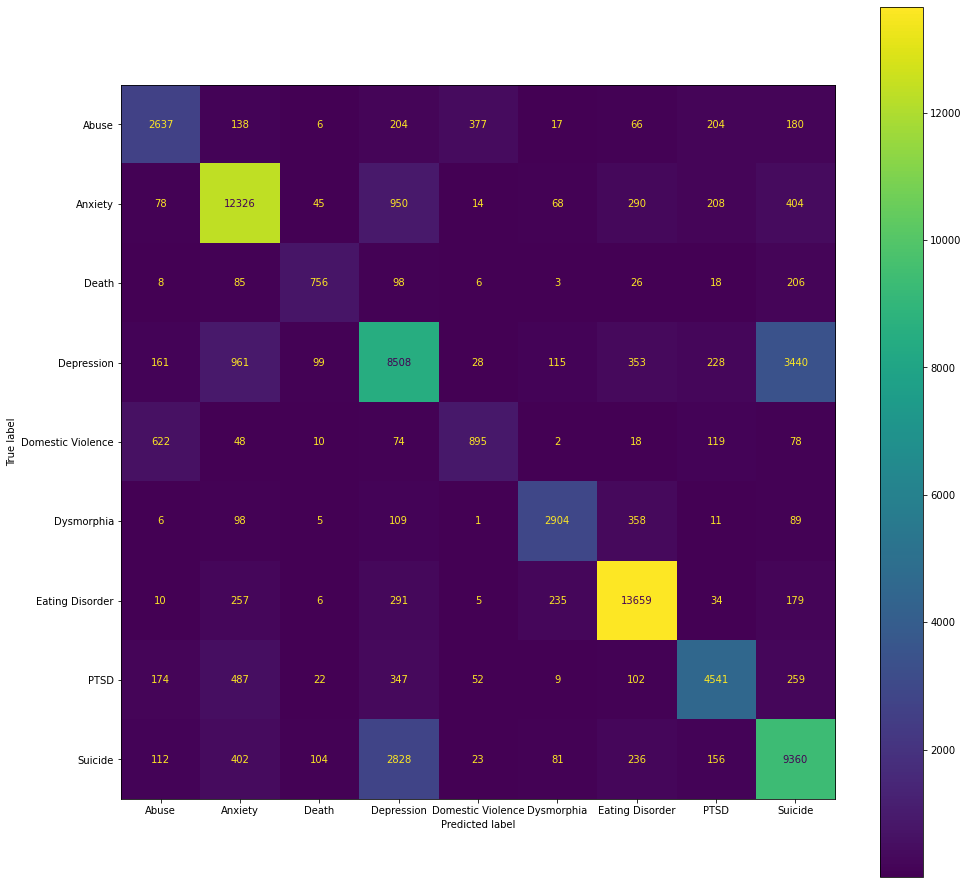

In [55]:
fig, ax = plt.subplots(figsize=(16, 16))
x=sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(y_test_enc, preds_SVM),display_labels=labes)
x.plot(ax=ax)
plt.show()

NB

In [77]:
from sklearn.naive_bayes import MultinomialNB

In [78]:
mnb = MultinomialNB()
mnb.fit(Train_X_trans,y_train_enc)
preds_nb = mnb.predict(Test_X_trans)
print(mnb.score(Test_X_trans,y_test_enc))
print(mnb.get_params())

0.7017558332989592
{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}


In [79]:
print("NB Accuracy Score", accuracy_score(y_test_enc, preds_nb))
print("Confusion matrix:\n",sklearn.metrics.confusion_matrix(y_test_enc, preds_nb))
print("F1:",sklearn.metrics.f1_score(y_test_enc, preds_nb,average='weighted'))
print("Precision:", sklearn.metrics.precision_score(y_test_enc, preds_nb,average='weighted'))
print("Recall:", sklearn.metrics.recall_score(y_test_enc, preds_nb,average='weighted'))
print("Classification Report:\n",sklearn.metrics.classification_report(y_test_enc, preds_nb, target_names=labes))

NB Accuracy Score 0.7017558332989592
Confusion matrix:
 [[ 2444   156     0   440   243    11    50   216   269]
 [  131 11403    14  1743    17    73   390   182   430]
 [   10   174   295   241     7     4    26    42   407]
 [  144  1458     5  8222    28    72   331   140  3493]
 [  712    60     1   132   664     1     7   161   128]
 [   10   161     0   249     0  2526   506    17   112]
 [   13   504     2   426     0   278 13196    43   214]
 [  274  1159     5   654    61     7    99  3375   359]
 [  105   541     8  3357    24    57   199    98  8913]]
F1: 0.6994371225196885
Precision: 0.7103976550274496
Recall: 0.7017558332989592
Classification Report:
                    precision    recall  f1-score   support

            Abuse       0.64      0.64      0.64      3829
          Anxiety       0.73      0.79      0.76     14383
            Death       0.89      0.24      0.38      1206
       Depression       0.53      0.59      0.56     13893
Domestic Violence       0.64  

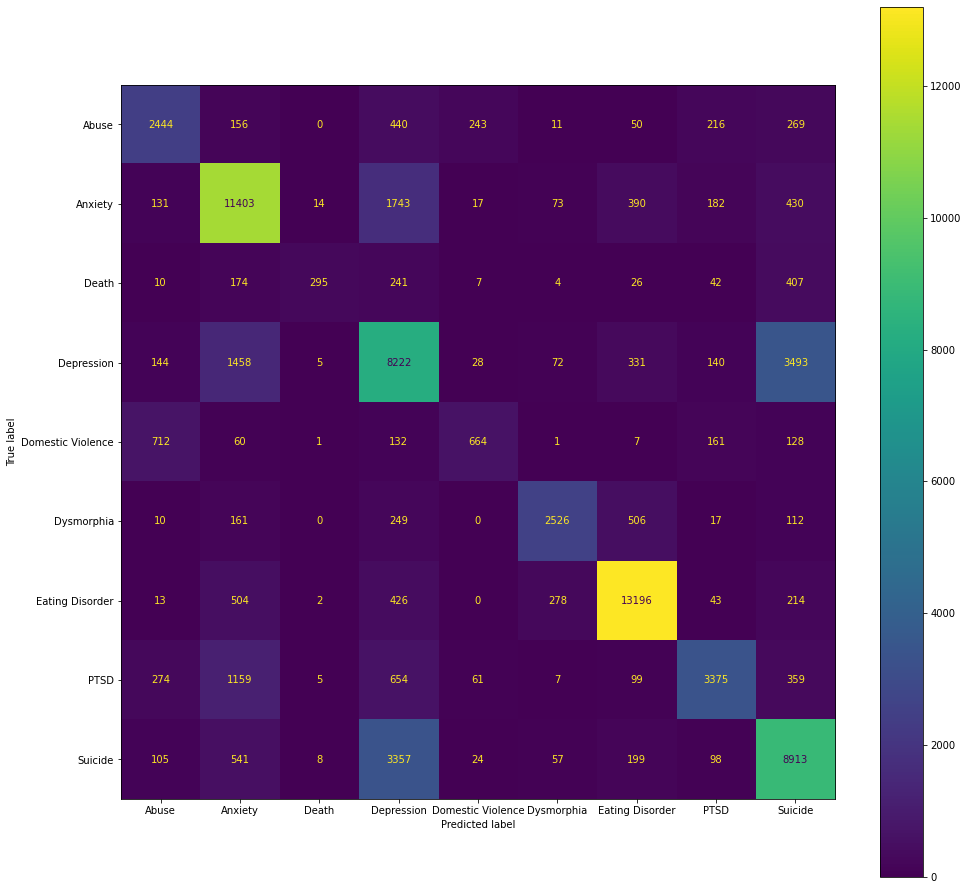

In [80]:
fig, ax = plt.subplots(figsize=(16, 16))
x=sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(y_test_enc, preds_nb),display_labels=labes)
x.plot(ax=ax)
plt.show()

Feed-Forward Neural Network (NN) with the following architecture (similar to that discussed by DOI: 10.1038/srep45141):
- Embedding layer word vec dimension of 300. 
- flattened layer
- dropout filter for 0.25
- dense structure with 64 (FF)
- Output layer with softmax activation 

using categorial cross entropy.

We will use word embeddings from the Word2Vec to input into the neural networks (instead of TF-IDF). Using CBOW defaults and window set to 5 as suggested in Kim et al [https://doi.org/10.1038/s41598-020-68764-y]

In [16]:
import gensim
import keras
from gensim.models import Word2Vec
from tensorflow.keras import utils as np_utils
from tensorflow.keras import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models, layers

In [56]:
X = df['token_text']
Y = df['class']

In [57]:
word_embeddings_model = Word2Vec(X,window=5,size=300)


In [87]:
print(word_embeddings_model)

Word2Vec(vocab=45171, size=300, alpha=0.025)


In [58]:
max_seq_len = max([len(s) for s in X])
print(max_seq_len)

3341


In [59]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,Y,random_state = 42, test_size=0.2, stratify=Y)

In [60]:
# change to x test and train sets
token = Tokenizer()
token.fit_on_texts(X)
X_train = token.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, max_seq_len)
X_test = token.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, max_seq_len)

In [61]:
# change this to deal with train and test sets
encoder = LabelEncoder()
encoder.fit(classes_names)
Y_test = encoder.fit_transform(y_test)
Y_test = np_utils.to_categorical(np.asarray(Y_test))
Y_train = encoder.fit_transform(y_train)
Y_train = np_utils.to_categorical(np.asarray(Y_train))
print(encoder.classes_)
print(Y_train[0])

['Abuse' 'Anxiety' 'Death' 'Depression' 'Domestic Violence' 'Dysmorphia'
 'Eating Disorder' 'PTSD' 'Suicide']
[0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [28]:
X_train.shape

(290912, 3341)

In [29]:
Y_train.shape

(290912, 9)

In [62]:
EMBED_DIM = 300
VOCAB_SIZE = len(token.word_index)+1

In [63]:
# create embedding matrix (https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)
word_index = token.word_index
embedding_matrix = np.zeros(shape=(VOCAB_SIZE,EMBED_DIM))
for word, i in word_index.items():
  try:
    embedding_vector = word_embeddings_model[word]
      # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector
  except:
    pass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [64]:
# build the keras model
FF_model = models.Sequential() #remove max input length seq parameter?
FF_model.add(layers.Embedding(VOCAB_SIZE,EMBED_DIM,weights=[embedding_matrix],input_length=max_seq_len, trainable=False))
FF_model.add(layers.Flatten())
FF_model.add(layers.Dropout(0.25))
FF_model.add(layers.Dense(64,activation='relu'))
FF_model.add(layers.Dense(9, activation='softmax'))


In [31]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='loss', patience=5)

In [65]:
FF_model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [66]:
FF_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3341, 300)         64113300  
                                                                 
 flatten_1 (Flatten)         (None, 1002300)           0         
                                                                 
 dropout_1 (Dropout)         (None, 1002300)           0         
                                                                 
 dense_2 (Dense)             (None, 64)                64147264  
                                                                 
 dense_3 (Dense)             (None, 9)                 585       
                                                                 
Total params: 128,261,149
Trainable params: 64,147,849
Non-trainable params: 64,113,300
_________________________________________________________________


In [67]:
FF_model.fit(X_train,Y_train, epochs=100,batch_size=64, validation_data=(X_test,Y_test),callbacks=callback)

Epoch 1/100
4546/4546 [==============================] - 96s 21ms/step - loss: 1.0359 - accuracy: 0.6271 - val_loss: 0.9182 - val_accuracy: 0.6691
Epoch 2/100
4546/4546 [==============================] - 95s 21ms/step - loss: 0.8190 - accuracy: 0.7033 - val_loss: 0.9198 - val_accuracy: 0.6742
Epoch 3/100
4546/4546 [==============================] - 95s 21ms/step - loss: 0.7233 - accuracy: 0.7364 - val_loss: 0.9399 - val_accuracy: 0.6797
Epoch 4/100
4546/4546 [==============================] - 96s 21ms/step - loss: 0.6530 - accuracy: 0.7590 - val_loss: 0.9767 - val_accuracy: 0.6725
Epoch 5/100
4546/4546 [==============================] - 95s 21ms/step - loss: 0.6045 - accuracy: 0.7757 - val_loss: 1.0094 - val_accuracy: 0.6654
Epoch 6/100
4546/4546 [==============================] - 96s 21ms/step - loss: 0.5650 - accuracy: 0.7895 - val_loss: 1.0645 - val_accuracy: 0.6691
Epoch 7/100
4546/4546 [==============================] - 95s 21ms/step - loss: 0.5388 - accuracy: 0.7981 - val_loss: 1

In [ ]:
# OVERFITTING ISSUES BECAUSE IT IS COMPLEX

In [68]:
FF_predictions = FF_model.predict(X_test, batch_size=64)

In [69]:

print(sklearn.metrics.classification_report(Y_test.argmax(axis=1),FF_predictions.argmax(axis=1), target_names=encoder.classes_))
print("Confusion matrix:\n",sklearn.metrics.confusion_matrix(Y_test.argmax(axis=1),FF_predictions.argmax(axis=1)))
print("F1:",sklearn.metrics.f1_score(Y_test.argmax(axis=1),FF_predictions.argmax(axis=1),average='weighted'))
print("Precision:", sklearn.metrics.precision_score(Y_test.argmax(axis=1),FF_predictions.argmax(axis=1),average='weighted'))
print("Recall:", sklearn.metrics.recall_score(Y_test.argmax(axis=1),FF_predictions.argmax(axis=1),average='weighted'))
print("Classification Report:\n",sklearn.metrics.classification_report(Y_test.argmax(axis=1),FF_predictions.argmax(axis=1), target_names=labes))


                   precision    recall  f1-score   support

            Abuse       0.58      0.47      0.52      3829
          Anxiety       0.73      0.74      0.74     14383
            Death       0.53      0.44      0.48      1206
       Depression       0.50      0.46      0.48     13893
Domestic Violence       0.36      0.40      0.38      1866
       Dysmorphia       0.66      0.63      0.65      3581
  Eating Disorder       0.86      0.85      0.85     14676
             PTSD       0.60      0.54      0.57      5993
          Suicide       0.54      0.64      0.59     13302

         accuracy                           0.64     72729
        macro avg       0.59      0.57      0.58     72729
     weighted avg       0.64      0.64      0.64     72729

Confusion matrix:
 [[ 1784   131    13   341   810    47    60   353   290]
 [  143 10640    66  1464    54   184   472   590   770]
 [    9   116   535   133    19     8    31    74   281]
 [  174  1377   130  6403   108   184   

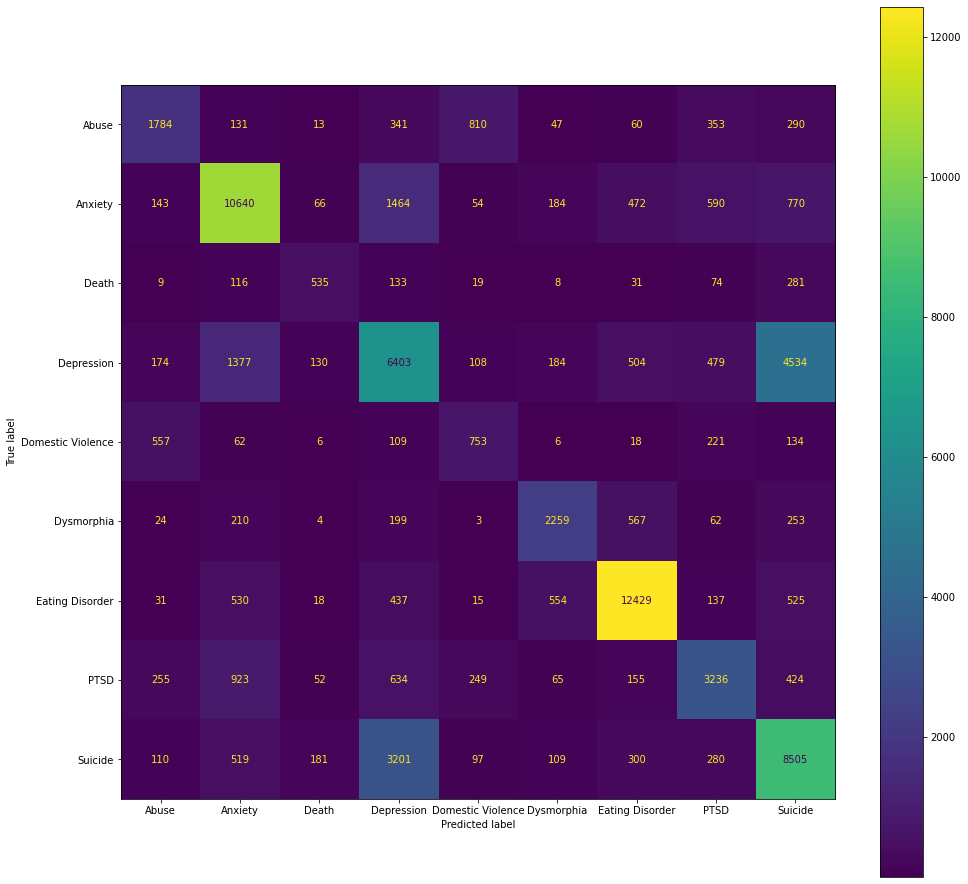

In [70]:
fig, ax = plt.subplots(figsize=(16, 16))
x=sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(Y_test.argmax(axis=1), FF_predictions.argmax(axis=1)),display_labels=labes)
x.plot(ax=ax)
plt.show()

In [71]:
print("Confusion matrix:\n",sklearn.metrics.confusion_matrix(Y_test.argmax(axis=1), FF_predictions.argmax(axis=1)))

Confusion matrix:
 [[ 1784   131    13   341   810    47    60   353   290]
 [  143 10640    66  1464    54   184   472   590   770]
 [    9   116   535   133    19     8    31    74   281]
 [  174  1377   130  6403   108   184   504   479  4534]
 [  557    62     6   109   753     6    18   221   134]
 [   24   210     4   199     3  2259   567    62   253]
 [   31   530    18   437    15   554 12429   137   525]
 [  255   923    52   634   249    65   155  3236   424]
 [  110   519   181  3201    97   109   300   280  8505]]


In [72]:
print(sklearn.metrics.label_ranking_average_precision_score(Y_test,FF_predictions))

0.778693975264132


**CNN** Gtkosis

In [72]:
# build the keras model
CNN_model = models.Sequential() #remove max input length seq parameter?
CNN_model.add(layers.Embedding(VOCAB_SIZE,EMBED_DIM,weights=[embedding_matrix],input_length=max_seq_len, trainable=False))
CNN_model.add(layers.Conv1D(5,3,activation='relu'))
CNN_model.add(layers.MaxPooling1D(2))
CNN_model.add(layers.Flatten())
CNN_model.add(layers.Dropout(0.25))
CNN_model.add(layers.Dense(256,activation='relu'))
CNN_model.add(layers.Dense(9, activation='sigmoid'))

CNN_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 3341, 300)         64113300  
                                                                 
 conv1d_1 (Conv1D)           (None, 3339, 5)           4505      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1669, 5)          0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 8345)              0         
                                                                 
 dropout_2 (Dropout)         (None, 8345)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2136576   
                                                      

In [73]:
CNN_model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [74]:
CNN_model.fit(X_train,Y_train, epochs=100,batch_size=64, validation_data=(X_test,Y_test),callbacks=callback)

Epoch 1/100
4546/4546 [==============================] - 57s 12ms/step - loss: 0.9412 - accuracy: 0.6538 - val_loss: 0.8035 - val_accuracy: 0.7019
Epoch 2/100
4546/4546 [==============================] - 56s 12ms/step - loss: 0.8384 - accuracy: 0.6908 - val_loss: 0.7895 - val_accuracy: 0.7062
Epoch 3/100
4546/4546 [==============================] - 56s 12ms/step - loss: 0.8157 - accuracy: 0.6992 - val_loss: 0.7811 - val_accuracy: 0.7117
Epoch 4/100
4546/4546 [==============================] - 56s 12ms/step - loss: 0.7991 - accuracy: 0.7053 - val_loss: 0.7825 - val_accuracy: 0.7122
Epoch 5/100
4546/4546 [==============================] - 56s 12ms/step - loss: 0.7872 - accuracy: 0.7090 - val_loss: 0.7810 - val_accuracy: 0.7156
Epoch 6/100
4546/4546 [==============================] - 56s 12ms/step - loss: 0.7791 - accuracy: 0.7118 - val_loss: 0.7895 - val_accuracy: 0.7137
Epoch 7/100
4546/4546 [==============================] - 56s 12ms/step - loss: 0.7693 - accuracy: 0.7152 - val_loss: 0

In [75]:
CNN_preds = CNN_model.predict(X_test, batch_size=64)
print(sklearn.metrics.classification_report(Y_test.argmax(axis=1),CNN_preds.argmax(axis=1), target_names=encoder.classes_))
print("Confusion matrix:\n",sklearn.metrics.confusion_matrix(Y_test.argmax(axis=1),CNN_preds.argmax(axis=1)))

                   precision    recall  f1-score   support

            Abuse       0.56      0.65      0.60      3829
          Anxiety       0.81      0.82      0.81     14383
            Death       0.53      0.51      0.52      1206
       Depression       0.58      0.51      0.54     13893
Domestic Violence       0.42      0.21      0.28      1866
       Dysmorphia       0.81      0.69      0.75      3581
  Eating Disorder       0.86      0.92      0.89     14676
             PTSD       0.80      0.63      0.70      5993
          Suicide       0.58      0.71      0.64     13302

         accuracy                           0.71     72729
        macro avg       0.66      0.63      0.64     72729
     weighted avg       0.71      0.71      0.70     72729

Confusion matrix:
 [[ 2491   126     8   185   372    16   110   186   335]
 [  105 11729    88  1147    12    66   487   262   487]
 [    9    63   613   124     7     5    15    30   340]
 [  183  1077   165  7038    18   147   

**CNN ** Kim et al **architecture**

In [28]:
#different CNN model
CNN_model3 = models.Sequential() #remove max input length seq parameter?
CNN_model3.add(layers.Embedding(VOCAB_SIZE,EMBED_DIM,weights=[embedding_matrix],input_length=max_seq_len, trainable=False))
CNN_model3.add(layers.Conv1D(128,5,activation='relu'))
CNN_model3.add(layers.MaxPooling1D(128))
CNN_model3.add(layers.Flatten())
CNN_model3.add(layers.Dropout(0.25))
CNN_model3.add(layers.Dense(128,activation='relu'))
CNN_model3.add(layers.Dense(9, activation='sigmoid'))

CNN_model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3341, 300)         64113300  
                                                                 
 conv1d (Conv1D)             (None, 3337, 128)         192128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 26, 128)          0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 3328)              0         
                                                                 
 dropout_1 (Dropout)         (None, 3328)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               426112    
                                                      

In [29]:
CNN_model3.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [30]:
CNN_model3.fit(X_train,Y_train, epochs=100,batch_size=64, validation_data=(X_test,Y_test),callbacks=callback)

Epoch 1/100
4546/4546 [==============================] - 216s 46ms/step - loss: 0.8806 - accuracy: 0.6780 - val_loss: 0.7750 - val_accuracy: 0.7111
Epoch 2/100
4546/4546 [==============================] - 208s 46ms/step - loss: 0.7894 - accuracy: 0.7084 - val_loss: 0.7616 - val_accuracy: 0.7162
Epoch 3/100
4546/4546 [==============================] - 207s 46ms/step - loss: 0.7617 - accuracy: 0.7173 - val_loss: 0.7505 - val_accuracy: 0.7196
Epoch 4/100
4546/4546 [==============================] - 208s 46ms/step - loss: 0.7401 - accuracy: 0.7245 - val_loss: 0.7521 - val_accuracy: 0.7207
Epoch 5/100
4546/4546 [==============================] - 207s 46ms/step - loss: 0.7244 - accuracy: 0.7297 - val_loss: 0.7448 - val_accuracy: 0.7217
Epoch 6/100
4546/4546 [==============================] - 207s 46ms/step - loss: 0.7096 - accuracy: 0.7347 - val_loss: 0.7521 - val_accuracy: 0.7216
Epoch 7/100
4546/4546 [==============================] - 208s 46ms/step - loss: 0.6961 - accuracy: 0.7392 - val_

In [31]:
CNN_preds3 = CNN_model3.predict(X_test, batch_size=64)
print(sklearn.metrics.classification_report(Y_test.argmax(axis=1),CNN_preds3.argmax(axis=1), target_names=encoder.classes_))
print("Confusion matrix:\n",sklearn.metrics.confusion_matrix(Y_test.argmax(axis=1),CNN_preds3.argmax(axis=1)))

                   precision    recall  f1-score   support

            Abuse       0.66      0.58      0.61      3829
          Anxiety       0.79      0.80      0.80     14383
            Death       0.67      0.53      0.59      1206
       Depression       0.58      0.52      0.55     13893
Domestic Violence       0.53      0.48      0.51      1866
       Dysmorphia       0.79      0.70      0.74      3581
  Eating Disorder       0.87      0.84      0.86     14676
             PTSD       0.76      0.69      0.73      5993
          Suicide       0.55      0.70      0.61     13302

         accuracy                           0.70     72729
        macro avg       0.69      0.65      0.67     72729
     weighted avg       0.71      0.70      0.70     72729

Confusion matrix:
 [[ 2205   117     9   244   650    15    62   264   263]
 [   92 11534    46   966    19   101   411   338   876]
 [    6   109   634   138     1     0    18    21   279]
 [  156  1214    98  7279    36    94   

In [35]:
print(sklearn.metrics.label_ranking_average_precision_score(Y_test,CNN_preds3))

0.8177863156702602


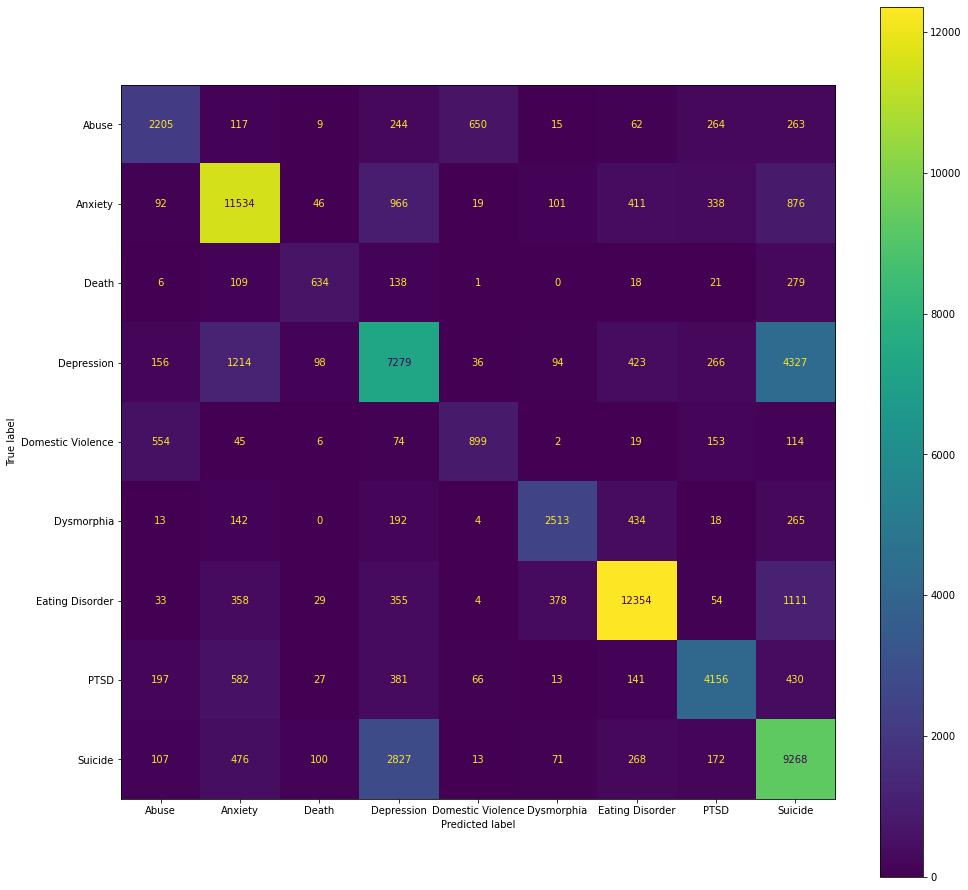

In [66]:
fig, ax = plt.subplots(figsize=(16, 16))
x=sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(Y_test.argmax(axis=1),CNN_preds3.argmax(axis=1)),display_labels=labes)
x.plot(ax=ax)
plt.show()


In [36]:
print("Accuracy Score", accuracy_score(Y_test.argmax(axis=1),CNN_preds3.argmax(axis=1)))
print("F1:",sklearn.metrics.f1_score(Y_test.argmax(axis=1),CNN_preds3.argmax(axis=1),average='weighted'))
print("Precision:", sklearn.metrics.precision_score(Y_test.argmax(axis=1),CNN_preds3.argmax(axis=1),average='weighted'))
print("Recall:", sklearn.metrics.recall_score(Y_test.argmax(axis=1),CNN_preds3.argmax(axis=1),average='weighted'))

Accuracy Score 0.699060897303689
F1: 0.6997463659719719
Precision: 0.7056250691751461
Recall: 0.699060897303689
